In [1]:
## Import Libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import os
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (15,10)
3

3

In [2]:
os.chdir('/home/cht104/data_q2/40_5000_320_500')

In [3]:
## Reading in Data + Feature generation + aggregation by 10 seconds
train_data=['40_40_5000_a.csv', '40_40_5000_b.csv', '40_40_5000_c.csv','40_40_5000_d.csv', '40_40_5000_e.csv','40_40_5000_m.csv','40_5000_160_1250_a.csv', '40_40_5000_f.csv', 
       '40_40_5000_g.csv', '40_5000_160_1250_b.csv','40_40_5000_h.csv', '40_40_5000_i.csv', '40_5000_160_1250_c.csv', '40_40_5000_j.csv', 
       '40_5000_160_1250_d.csv','40_40_5000_k.csv','40_40_5000_l.csv', '40_5000_160_1250_e.csv']
test_data = ['40_40_5000_n.csv','40_40_5000_o.csv','40_5000_320_1250_b.csv','40_40_5000_p.csv','40_40_5000_q.csv','40_40_5000_r.csv','40_5000_320_500_a.csv',
            '40_40_5000_s.csv','40_5000_320_1250_c.csv', '40_5000_320_1250_a.csv','40_5000_320_500_b.csv','40_5000_320_500_c.csv']
def aggregate_data(data, n):
    df = pd.DataFrame(pd.read_csv(data[0])[20:].reset_index().drop('index',axis=1))
    df['total_pkts'] = df['1->2Pkts'] + df['2->1Pkts']
    df = df[df['total_pkts'] >1].reset_index().drop('index',axis=1)
    df['anom'] = 0
    df.loc[160:,'anom'] = 1
    for file in data[1:]:
        dff = pd.DataFrame(pd.read_csv(file)[20:]).reset_index().drop('index',axis=1)
        dff['total_pkts'] = dff['1->2Pkts'] +df['2->1Pkts']
        dff = dff[dff.total_pkts > 1].reset_index().drop('index',axis=1)
        dff['anom'] = 0
        dff.loc[160:,'anom'] = 1
        df=  pd.concat([df,dff],ignore_index=True)
    df = df[:len(df) - (len(df) %n)]
    df_agg = pd.DataFrame([df[:n]['total_pkts'].mean(), df[:n]['anom'].max()],index=['total_pkts','anom']).T
    for i in range(n,df.shape[0],n):
        df_agg = pd.concat([df_agg,pd.DataFrame([df[i:i+n]['total_pkts'].mean(),df[i:i+n]['anom'].max()],index=['total_pkts','anom']).T],ignore_index=True)
    return df_agg,df
DF,df = aggregate_data(train_data,20)
test_df,dff = aggregate_data(test_data,20)

In [4]:
test_ = pd.concat([DF,test_df]).reset_index().drop('index',axis=1)


In [22]:
def eval_arima(X,arima_order,conf,n):
    train, test = X[:n], X[n:]
    history = [x for x in train]
    predictions = list()
    anomalies=[]
    upperLim=[]
    lowerLim=[]
    for t in range(n,len(test)+n):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        result = model_fit.get_forecast()
        conf_int = result.conf_int(alpha=conf)
        upperLim.append(conf_int[0,1])
        lowerLim.append(conf_int[0,0])
        if obs >= conf_int[0,0] and obs <= conf_int[0,1]:
            anomalies.append(0)
        else:
            anomalies.append(1)
    rmse = mean_squared_error(test, predictions, squared=False)
    return model_fit.aic,model_fit,test,predictions,anomalies,upperLim,lowerLim

def eval_models(dataset, p_vals,q_vals,d_vals, conf, n):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                order = (p,d,q)
                try:
                    aic,model_fit,test,predictions,anomalies,upperLim,lowerLim = eval_arima(dataset, order,conf,n)
                    best_score, best_cfg = aic, order
                    print('ARIMA%s RMSE=%.3f' % (order,aic))
                except:
                    continue
def plot_results(preds, data,anomalies, n, log=False):
    preds = pd.DataFrame(preds)
    preds['time'] = np.arange(n,len(preds)+n)
    preds= preds.rename({0:'preds'},axis=1).set_index('time')
    preds['anomaly'] = anomalies
    preds['actual'] =data.total_pkts[n:]
    anom = preds[preds.anomaly==1]
    if log == True:
        plt.plot(np.log(data.total_pkts),label='actual')
        plt.plot(preds.preds,label='preds')
        plt.scatter(anom.index,np.log(anom.actual),label='anomaly',c='r',s=100)
    if log == False:
        plt.plot(data.total_pkts,label='actual')
        plt.scatter(anom.index,anom.actual,label='anomaly',c='r',s=100)
    plt.legend()
    plt.xlabel('Time (10s)')
    plt.ylabel('Total Packets Sent')
    plt.title('Anomaly Detection 40-5000-320-1250 (99% CI)')
    plt.savefig('output.png', dpi=300)
p_values = np.arange(1,4)
d_values = range(2)
q_values = np.arange(1,4)
# eval_models(np.log(DF.total_pkts), p_values, q_values, d_values, .01, 70)

In [14]:
rmse, model, test, preds,anomalies,upper,lower= eval_arima(np.log(DF.total_pkts), (3,0,2),.01,75)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


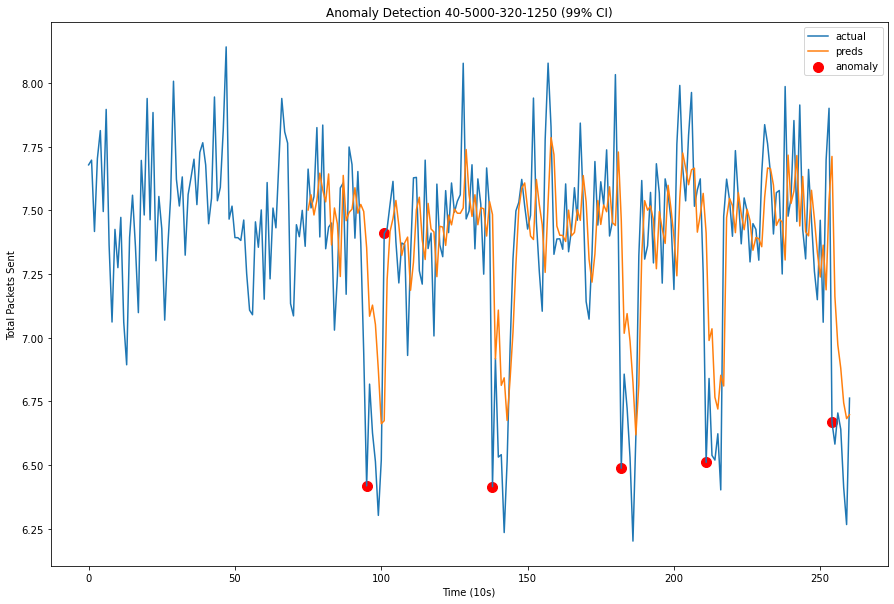

In [24]:
plot_results(preds,DF,anomalies,75, log=True)

In [25]:
rmse, model, test, preds,anomalies,upper,lower= eval_arima(np.log(test_.total_pkts), (3,0,2),.01,75)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


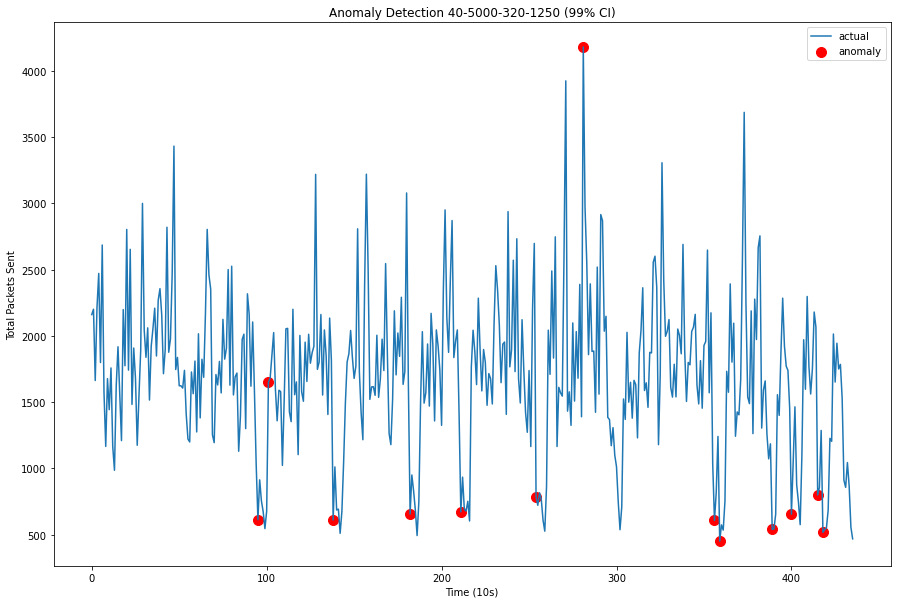

In [37]:
plot_results(preds,test_,anomalies,75,log=False)